In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

26427392it [00:02, 9914906.13it/s]                                                                                     


Extracting ../data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw


32768it [00:00, 96637.59it/s]                                                                                          


Extracting ../data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw


4423680it [00:01, 3192914.41it/s]                                                                                      


Extracting ../data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw


8192it [00:00, 28092.61it/s]                                                                                           


Extracting ../data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST\FashionMNIST\raw
Processing...
Done!


## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

C:\Users\Admin\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/60000 (0%)]	Loss: 2.469361	Accuracy: 7.03125
Train: [12800/60000 (21%)]	Loss: 2.841928	Accuracy: 11.519607843137255
Train: [25600/60000 (43%)]	Loss: 2.176782	Accuracy: 16.41398514851485
Train: [38400/60000 (64%)]	Loss: 1.514944	Accuracy: 25.111237582781456
Train: [51200/60000 (85%)]	Loss: 1.085132	Accuracy: 33.22838930348259
Epoch: 1/20. Train set: Average loss: 1.7454	Accuracy: 38.71
Epoch: 1/20. Validation set: Average loss: 0.7876	Accuracy: 71.36
Train: [0/60000 (0%)]	Loss: 0.779949	Accuracy: 70.3125
Train: [12800/60000 (21%)]	Loss: 0.723771	Accuracy: 72.96262254901961
Train: [25600/60000 (43%)]	Loss: 0.666004	Accuracy: 73.84359529702971
Train: [38400/60000 (64%)]	Loss: 0.585316	Accuracy: 75.45012417218543
Train: [51200/60000 (85%)]	Loss: 0.566534	Accuracy: 76.82097325870647
Epoch: 2/20. Train set: Average loss: 0.6218	Accuracy: 77.51
Epoch: 2/20. Validation set: Average loss: 0.5779	Accuracy: 79.93
Train: [0/60000 (0%)]	Loss: 0.544711	Accuracy: 80.46875
Train: [12800/6000

Train: [38400/60000 (64%)]	Loss: 0.145154	Accuracy: 95.19350165562913
Train: [51200/60000 (85%)]	Loss: 0.140602	Accuracy: 95.18617848258707
Epoch: 18/20. Train set: Average loss: 0.1407	Accuracy: 95.19833333333334
Epoch: 18/20. Validation set: Average loss: 0.3977	Accuracy: 90.32
Train: [0/60000 (0%)]	Loss: 0.097273	Accuracy: 97.265625
Train: [12800/60000 (21%)]	Loss: 0.133780	Accuracy: 95.35845588235294
Train: [25600/60000 (43%)]	Loss: 0.137338	Accuracy: 95.38211633663366
Train: [38400/60000 (64%)]	Loss: 0.141602	Accuracy: 95.2918046357616
Train: [51200/60000 (85%)]	Loss: 0.141016	Accuracy: 95.25419776119404
Epoch: 19/20. Train set: Average loss: 0.1390	Accuracy: 95.26666666666667
Epoch: 19/20. Validation set: Average loss: 0.3976	Accuracy: 90.36
Train: [0/60000 (0%)]	Loss: 0.105462	Accuracy: 96.484375
Train: [12800/60000 (21%)]	Loss: 0.134935	Accuracy: 95.50398284313725
Train: [25600/60000 (43%)]	Loss: 0.144793	Accuracy: 95.21967821782178
Train: [38400/60000 (64%)]	Loss: 0.138182	Acc

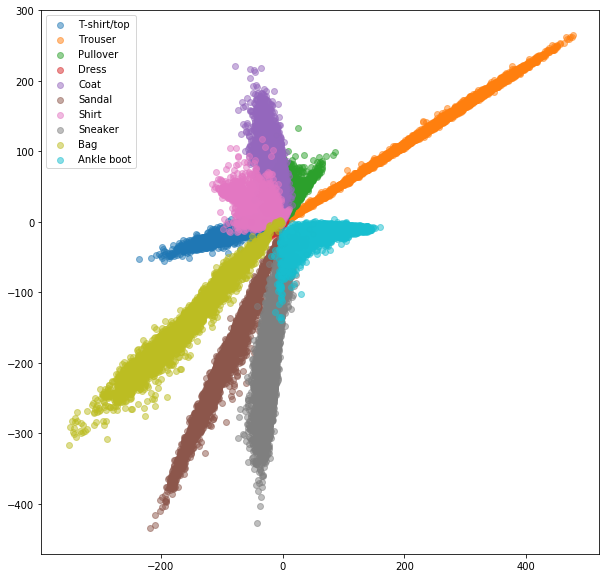

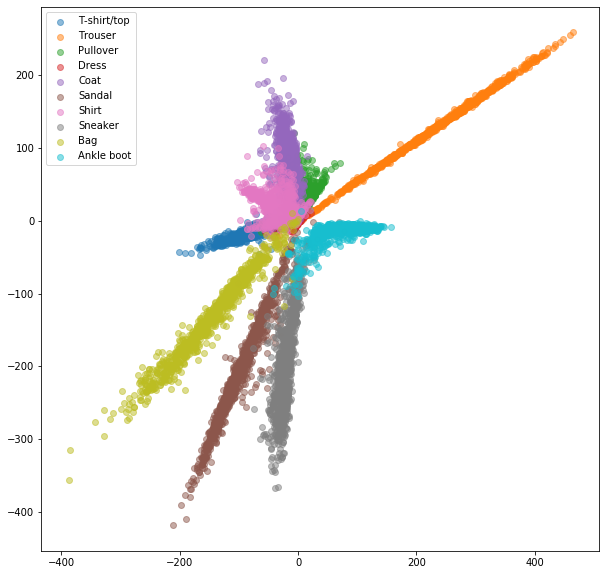

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Siamese network
We'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

## Steps
1. Create a dataset returning pairs - **SiameseMNIST** class from *datasets.py*, wrapper for MNIST-like classes.
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **siamese** network processing pairs of inputs - **SiameseNet** wrapping *EmbeddingNet*
4. Train the network with **ContrastiveLoss** - *losses.py*

In [7]:
# Set up data loaders
from datasets import SiameseMNIST

# Step 1
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

C:\Users\Admin\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Admin\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Admin\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Users\Admin\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.225896
Epoch: 1/20. Train set: Average loss: 0.0480
Epoch: 1/20. Validation set: Average loss: 0.0405
Train: [0/60000 (0%)]	Loss: 0.044731
Epoch: 2/20. Train set: Average loss: 0.0375
Epoch: 2/20. Validation set: Average loss: 0.0358
Train: [0/60000 (0%)]	Loss: 0.038229
Epoch: 3/20. Train set: Average loss: 0.0327
Epoch: 3/20. Validation set: Average loss: 0.0339
Train: [0/60000 (0%)]	Loss: 0.026965
Epoch: 4/20. Train set: Average loss: 0.0294
Epoch: 4/20. Validation set: Average loss: 0.0313
Train: [0/60000 (0%)]	Loss: 0.028295
Epoch: 5/20. Train set: Average loss: 0.0267
Epoch: 5/20. Validation set: Average loss: 0.0297
Train: [0/60000 (0%)]	Loss: 0.021015


KeyboardInterrupt: 

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [ ]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999715
Epoch: 1/20. Train set: Average loss: 0.1918
Epoch: 1/20. Validation set: Average loss: 0.1520
Train: [0/60000 (0%)]	Loss: 0.156159
Epoch: 2/20. Train set: Average loss: 0.1383
Epoch: 2/20. Validation set: Average loss: 0.1393
Train: [0/60000 (0%)]	Loss: 0.063343
Epoch: 3/20. Train set: Average loss: 0.1184
Epoch: 3/20. Validation set: Average loss: 0.1153
Train: [0/60000 (0%)]	Loss: 0.094688
Epoch: 4/20. Train set: Average loss: 0.1064
Epoch: 4/20. Validation set: Average loss: 0.1102
Train: [0/60000 (0%)]	Loss: 0.105735
Epoch: 5/20. Train set: Average loss: 0.0963
Epoch: 5/20. Validation set: Average loss: 0.1131
Train: [0/60000 (0%)]	Loss: 0.041875
Epoch: 6/20. Train set: Average loss: 0.0904
Epoch: 6/20. Validation set: Average loss: 0.1017
Train: [0/60000 (0%)]	Loss: 0.065105
Epoch: 7/20. Train set: Average loss: 0.0818
Epoch: 7/20. Validation set: Average loss: 0.1001
Train: [0/60000 (0%)]	Loss: 0.062069
Epoch: 8/20. Train set: Average loss: 0

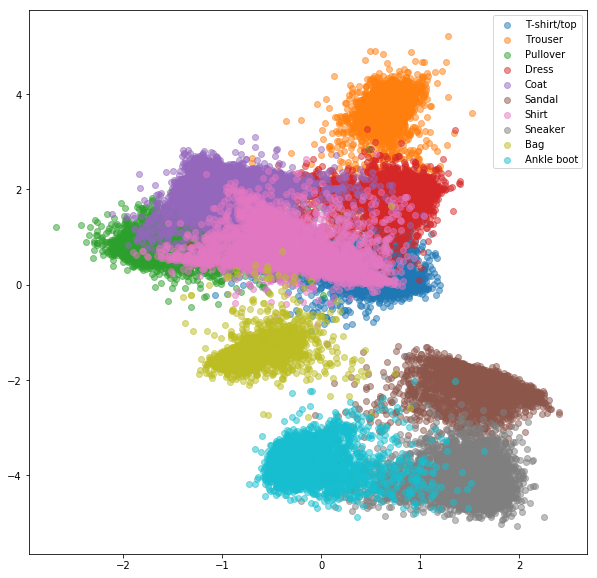

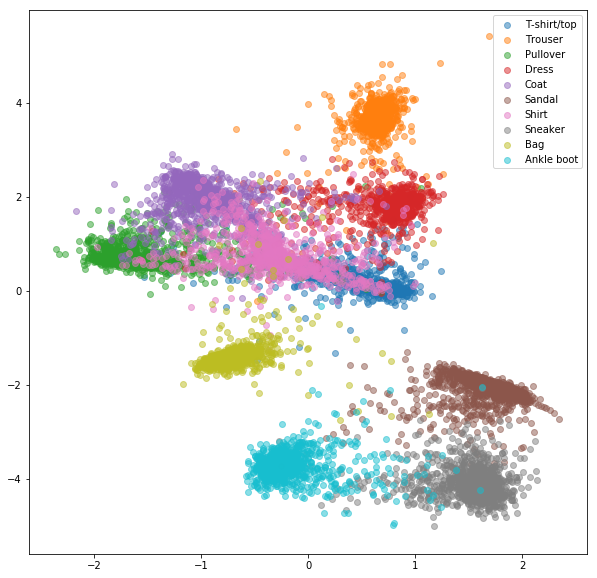

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

In [ ]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.493998
Epoch: 1/20. Train set: Average loss: 0.2507
Epoch: 1/20. Validation set: Average loss: 0.1949
Train: [0/60000 (0%)]	Loss: 0.165879
Epoch: 2/20. Train set: Average loss: 0.1766
Epoch: 2/20. Validation set: Average loss: 0.1708
Train: [0/60000 (0%)]	Loss: 0.159209
Epoch: 3/20. Train set: Average loss: 0.1499
Epoch: 3/20. Validation set: Average loss: 0.1661
Train: [0/60000 (0%)]	Loss: 0.129778
Epoch: 4/20. Train set: Average loss: 0.1323
Epoch: 4/20. Validation set: Average loss: 0.1534
Train: [0/60000 (0%)]	Loss: 0.126551
Epoch: 5/20. Train set: Average loss: 0.1175
Epoch: 5/20. Validation set: Average loss: 0.1478
Train: [0/60000 (0%)]	Loss: 0.110542
Epoch: 6/20. Train set: Average loss: 0.1049
Epoch: 6/20. Validation set: Average loss: 0.1458
Train: [0/60000 (0%)]	Loss: 0.136336
Epoch: 7/20. Train set: Average loss: 0.0951
Epoch: 7/20. Validation set: Average loss: 0.1439
Train: [0/60000 (0%)]	Loss: 0.058131
Epoch: 8/20. Train set: Average loss: 0

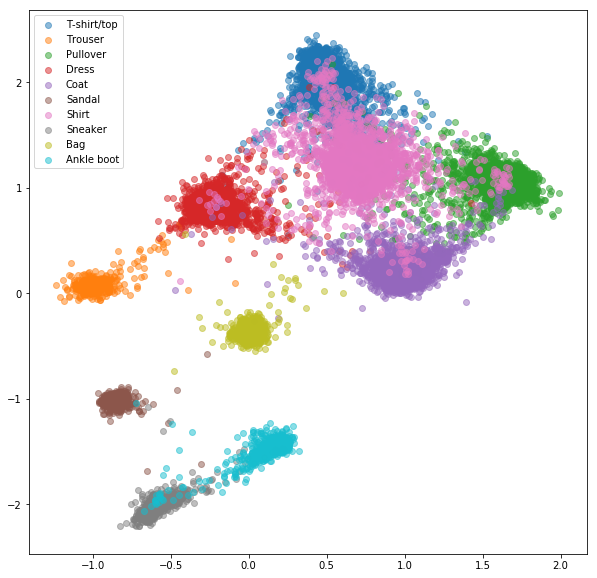

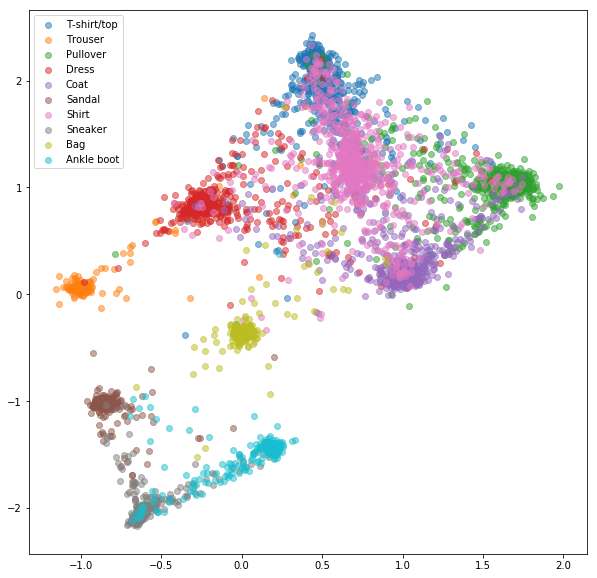

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999639	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.997169	Average nonzero triplets: 2497.5960264900664
Epoch: 1/20. Train set: Average loss: 1.0007	Average nonzero triplets: 2385.9205020920504
Epoch: 1/20. Validation set: Average loss: 0.8909	Average nonzero triplets: 2252.153846153846
Train: [0/60000 (0%)]	Loss: 1.134557	Average nonzero triplets: 2130.0
Train: [37500/60000 (62%)]	Loss: 0.992342	Average nonzero triplets: 2028.7549668874171
Epoch: 2/20. Train set: Average loss: 0.9942	Average nonzero triplets: 2020.702928870293
Epoch: 2/20. Validation set: Average loss: 1.0168	Average nonzero triplets: 1963.179487179487
Train: [0/60000 (0%)]	Loss: 1.016245	Average nonzero triplets: 2223.0
Train: [37500/60000 (62%)]	Loss: 0.995299	Average nonzero triplets: 1861.9933774834437
Epoch: 3/20. Train set: Average loss: 0.9963	Average nonzero triplets: 1852.1882845188284
Epoch: 3/20. Validation set: Average loss: 0.9350	Average nonzero triple

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_ocl, train_embeddings_cl, train_labels_ocl, train_labels_cl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_ocl, val_embeddings_cl, val_labels_ocl, val_labels_cl

x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))

plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)